# Matching Networks(Metrics Based Method)

#### Matching Networks Architecture

Matching networks, in general, proposes a framework which learns a network that maps a small training dataset and test unlabeled example to same embeddings space. Matching networks aim to learn the proper embeddings representation of small training dataset and use differentiable k-NN with cosine similarity measure to ensure whether a test data point is something ever seen or not.

Matching networks are designed to be two-fold:

Modeling level: At Modeling level, they proposed Matching nets, which uses advances made in attention and memory that enable fast and efficient learning.

Training procedure: At Training Level, they have one condition that distribution of training and test set must be the same. For example: show a few examples per class, switching the task from minibatch to minibatch, similar to how it will be tested when presented with a few examples of a new task.

As we have learned, Matching Networks Architecture implementation consists of following 5 important parts:

1. Embeddings Extractor, g.
2. Full Context Embeddings, Bi-directional LSTM, f
3. Cosine Similarity Distance Function, c
4. Attention Model: Softmax(c)
5. Loss Function: Cross Entropy Loss

##### Step 1: Import all necessary libraries

In [1]:
!pip install tqdm
!pip install matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import torch
import torch.nn as nn
import math
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
from PIL import Image
%matplotlib inline

#### Step 2: We will load RHA dataset, tranformed in .npy format using helper script.  
In helper script, we are just loading data in size format: [total_number,character,64,64].                             

In [4]:
def create_npy_from_folders(data_dir, img_size=(224, 224)):
    """
    Converts images in subfolders of `data_dir` into a numpy array and saves it as `data.npy`.
    Args:
        data_dir (str): Path to the dataset folder.
        img_size (tuple): Target size for resizing images (width, height).
    Returns:
        numpy.ndarray: The dataset array with shape (n_classes, n_samples, img_size[0], img_size[1]).
    """
    all_classes = sorted(os.listdir(data_dir))  # Sort to ensure consistency
    all_images = []
    min_samples = float('inf')  # Track the minimum number of images per class

    # Collect images and find the smallest class size
    for class_folder in all_classes:
        class_path = os.path.join(data_dir, class_folder)
        if not os.path.isdir(class_path):
            continue  # Skip non-folder entries
        class_images = []

        for img_file in sorted(os.listdir(class_path)):  # Sort to keep consistent order
            img_path = os.path.join(class_path, img_file)

            if img_file.endswith(('.png', '.jpg', '.jpeg')):
                # Open, convert to grayscale, and resize the image
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize(img_size)
                class_images.append(np.array(img))  # Add image as numpy array

        # Update the minimum number of samples across classes
        min_samples = min(min_samples, len(class_images))
        all_images.append(class_images)

    # Truncate all classes to the same number of samples (min_samples)
    truncated_images = [class_images[:min_samples] for class_images in all_images]

    # Convert to numpy array with consistent shape
    dataset = np.array(truncated_images)
    print(f"Dataset shape: {dataset.shape}")  # Should be (n_classes, min_samples, img_height, img_width)

    # Save to data.npy
    np.save('data.npy', dataset)
    return dataset

# Call the function
data_dir = '/content/drive/MyDrive/_projects/GEI_Project/Dataset_fewshot'  # Path to your folder
dataset = create_npy_from_folders(data_dir, img_size=(224, 224))

Dataset shape: (3, 98, 224, 224)


In [5]:
# Load the newly created data.npy
x = np.load('data.npy')  # Shape should be (3, 98, 224, 224)

# Print original dataset shape
print(f"Dataset shape: {x.shape}")

# Ensure the dataset is reshaped to include the channel dimension (grayscale -> 1 channel)
x = np.reshape(x, newshape=(x.shape[0], x.shape[1], 224, 224, 1))  # Shape becomes (3, 98, 224, 224, 1)

# Shuffle the dataset (shuffling is applied to all classes together)
np.random.shuffle(x)

# Split dataset into train, val, and test sets
# Let's allocate 70% to training, 15% to validation, and 15% to test (this can be adjusted)
train_size = int(0.7 * x.shape[1])  # 70% of the samples per class
val_size = int(0.15 * x.shape[1])   # 15% of the samples per class
test_size = x.shape[1] - train_size - val_size  # Remaining 15%

x_train = x[:, :train_size, :, :, :]  # Select the first 'train_size' images for each class
x_val = x[:, train_size:train_size+val_size, :, :, :]  # Select the next 'val_size' images
x_test = x[:, train_size+val_size:, :, :, :]  # Select the remaining images for testing

# Print the shape of each split
print(f"Train shape: {x_train.shape}")
print(f"Val shape: {x_val.shape}")
print(f"Test shape: {x_test.shape}")

Dataset shape: (3, 98, 224, 224)
Train shape: (3, 68, 224, 224, 1)
Val shape: (3, 14, 224, 224, 1)
Test shape: (3, 16, 224, 224, 1)


##### Preprocess Images: Here we have use normalization method.

In [6]:
# Normalize the dataset
def processes_batch(data, mu, sigma):
    return (data - mu) / sigma

x_train = processes_batch(x_train, np.mean(x_train), np.std(x_train))
x_val = processes_batch(x_val, np.mean(x_val), np.std(x_val))
x_test = processes_batch(x_test, np.mean(x_test), np.std(x_test))

# Define dataset dictionary

dataset = {"train": x_train, "val": x_val, "test": x_test}

print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"x_test shape: {x_test.shape}")
# Now you can use `dataset['train']`, `dataset['val']`, and `dataset['test']` for training.

x_train shape: (3, 68, 224, 224, 1)
x_val shape: (3, 14, 224, 224, 1)
x_test shape: (3, 16, 224, 224, 1)


Let's Visualize example of each class.

class 0


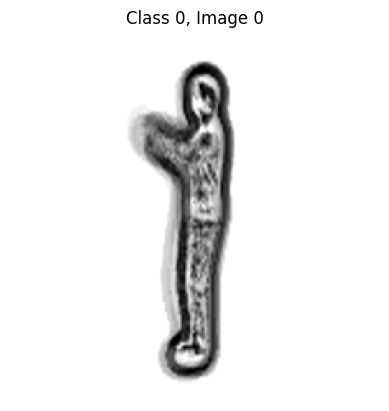

class 1


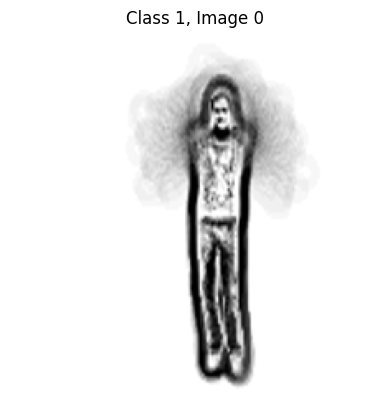

class 2


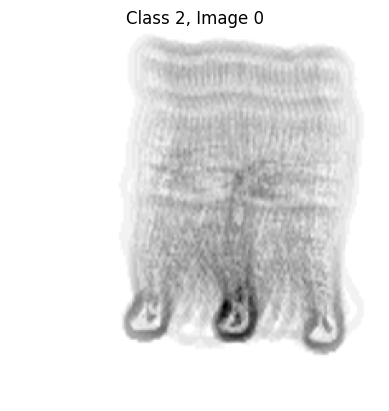

In [7]:
for class_idx in range(x_train.shape[0]):  # Loop over classes (3 classes in your case)
    print("class " + str(class_idx))
    # Extract the first image from the current class
    first_image = x_train[class_idx, 0, :, :]  # (height, width)

    # Plot the first image of each class
    plt.figure()
    plt.imshow(first_image, cmap='gray')  # Display as grayscale
    plt.title(f"Class {class_idx}, Image 0")  # Add a title with class index and image number
    plt.axis('off')  # Hide axis for better visualization
    plt.show()

###### Step 3: Training Data Processing
To Load dataset, and prepare it for Matching Networks Architecture, we need to create:
1. Label Set: Variable choose_label
2. Support Set: support_set_x, support_set_y
3. Batch from Suppport Set Examples

Let's first create a batch which can give a support set, and target set.

In [10]:
def sample_batch(data):
    """
    Generates a sample batch.
    :param data: Dataset with shape [total_classes, total_samples, image_height, image_width, num_channels]
    :return: [support_set_x, support_set_y, target_x, target_y] for Matching Networks
    """
    support_set_x = np.zeros((batch_size, classes_per_set, samples_per_class, data.shape[2],
                              data.shape[3], data.shape[4]), np.float32)
    support_set_y = np.zeros((batch_size, classes_per_set, samples_per_class), np.int32)

    target_x = np.zeros((batch_size, data.shape[2], data.shape[3], data.shape[4]), np.float32)
    target_y = np.zeros((batch_size, 1), np.int32)

    for i in range(batch_size):
        # Randomly choose `classes_per_set` classes
        chosen_classes = np.random.choice(data.shape[0], size=classes_per_set, replace=False)
        # Randomly select one class as the target class
        target_class_idx = np.random.choice(classes_per_set, size=1)
        # Randomly select `samples_per_class + 1` samples for support and target
        chosen_samples = np.random.choice(data.shape[1], size=samples_per_class + 1, replace=False)

        # Extract the data for the selected classes
        x_temp = data[chosen_classes]
        x_temp = x_temp[:, chosen_samples]  # Shape: [classes_per_set, samples_per_class + 1, height, width, channels]

        # Generate the labels
        y_temp = np.arange(classes_per_set)  # Labels: [0, 1, ..., classes_per_set - 1]

        # Assign to support and target sets
        support_set_x[i] = x_temp[:, :-1]  # All except the last sample
        support_set_y[i] = np.expand_dims(y_temp[:], axis=1)  # Expand to match dimensions
        target_x[i] = x_temp[target_class_idx, -1]  # The last sample of the chosen target class
        target_y[i] = y_temp[target_class_idx]  # Corresponding label for the target

    return support_set_x, support_set_y, target_x, target_y


def get_batch(dataset_name):
    """
    Generate a batch while training.
    :param dataset_name: The name of the dataset ("train", "val", "test").
    :return: A batch of images and labels.
    """
    support_set_x, support_set_y, target_x, target_y = sample_batch(dataset[dataset_name])

    # Reshape support set to merge classes and samples into a single sequence
    support_set_x = support_set_x.reshape((support_set_x.shape[0], support_set_x.shape[1] * support_set_x.shape[2],
                                           support_set_x.shape[3], support_set_x.shape[4], support_set_x.shape[5]))
    support_set_y = support_set_y.reshape(support_set_y.shape[0], support_set_y.shape[1] * support_set_y.shape[2])

    return support_set_x, support_set_y, target_x, target_y


If you recall, Matching Networks architecture, you will remember that there are mainly 4 parts of network:
1. Embeddings extractor(g)
2. Full-Context Embeddings(f)
2. Attention Model(a)
3. Distance Function(c)



so, In this section first we will create a classifier.

##### Step 4: Create an Embeddings extractor

In [20]:
def convLayer(in_channels, out_channels, dropout_prob=0.0):
    """
    A convolutional layer followed by ReLU, BatchNorm, MaxPool, and Dropout.
    """
    cnn_seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),  # 3x3 Conv, padding=1 to keep size
        nn.ReLU(True),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample by 2
        nn.Dropout(dropout_prob)  # Dropout layer to prevent overfitting
    )
    return cnn_seq

class Embeddings_extractor(nn.Module):
    def __init__(self, layer_size=64, num_channels=1, dropout_prob=0.5, image_size=224):
        super(Embeddings_extractor, self).__init__()

        """
        Build a CNN to produce embeddings for the dataset.
        :param layer_size: Number of channels in the convolutional layers
        :param num_channels: Number of channels in the input image (grayscale = 1)
        :param dropout_prob: Probability for dropout layers
        :param image_size: Input image size (224x224)
        """
        # Define the convolutional layers
        self.layer1 = convLayer(num_channels, layer_size, dropout_prob)
        self.layer2 = convLayer(layer_size, layer_size * 2, dropout_prob)  # Increase filters
        self.layer3 = convLayer(layer_size * 2, layer_size * 2, dropout_prob)
        self.layer4 = convLayer(layer_size * 2, layer_size * 4, dropout_prob)  # Increase filters again

        # Compute the output size after all convolution and pooling layers
        finalSize = int(math.floor(image_size / (2 * 2 * 2 * 2)))  # Pooling halved size 4 times
        self.outSize = finalSize * finalSize * layer_size * 4  # Adjusted for increased channels

    def forward(self, image_input):
        """
        Forward pass through the network to obtain embeddings.
        :param image_input: The input image
        :return: The embeddings from the final fully connected layer
        """
        # Pass through each convolutional block
        x = self.layer1(image_input)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Flatten the output to pass into a fully connected layer (embedding space)
        x = x.view(x.size()[0], -1)  # Flatten to (batch_size, out_features)
        return x


##### step 5: Create an Attention model after classifier.
a(x,x^)= softmax of cosine similarities

In [12]:
class AttentionalClassify(nn.Module):
    def __init__(self, num_classes):
        super(AttentionalClassify, self).__init__()
        self.num_classes = num_classes

    def forward(self, similarities, support_set_y):
        """
        Products pdfs over the support set classes for the target set image.
        :param similarities: A tensor with cosine similarities of size [batch_size, sequence_length]
        :param support_set_y: One-hot tensor of shape [batch_size, sequence_length, num_classes]
        :return: Softmax pdf with shape [batch_size, num_classes]
        """
        # Apply Softmax to similarities along sequence dimension (dim=1)
        softmax = nn.Softmax(dim=1)
        softmax_similarities = softmax(similarities)

        # Calculate weighted sum of support set labels based on similarity scores
        preds = softmax_similarities.unsqueeze(1).bmm(support_set_y).squeeze(1)
        return preds

#### Step 6: Create a Distance Network, which will take output from Test Image, and training embeddings, to calculate the Distance.

find cosine similarities between support set and input_test_image

In [13]:
class DistanceNetwork(nn.Module):
    """
    This model calculates the cosine distance between each of the support set embeddings and
    the target image embeddings.
    """

    def __init__(self, embedding_dim=64):
        super(DistanceNetwork, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, support_set, input_image):
        """
        forward pass
        :param support_set: The embeddings of the support set images, shape [n_classes, n_samples, embedding_dim]
        :param input_image: The embedding of the target image, shape [batch_size, embedding_dim]
        :return: similarities, shape [batch_size, n_classes]
        """
        eps = 1e-10
        similarities = []

        # Loop over each class in the support set
        for class_embeddings in support_set:
            # Calculate cosine similarity for all images in the current class with input_image
            sum_support = torch.sum(torch.pow(class_embeddings, 2), 1)
            support_magnitude = sum_support.clamp(eps, float("inf")).rsqrt()

            # Cosine similarity for each image in the support set with input image
            dot_product = input_image.unsqueeze(1).bmm(class_embeddings.unsqueeze(2)).squeeze()
            cosine_similarity = dot_product * support_magnitude
            similarities.append(cosine_similarity)

        # Stack similarities to get shape [batch_size, n_classes]
        similarities = torch.stack(similarities)
        return similarities.t()

##### Step 7:  Create a Bi-directional LSTM, which is taking input and output from Test-image, and put them in same embeddings space.  
If we wish to use full-context embeddings, Matching Networks introduced Bi-directional LSTM for it.

In [14]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, layer_size, batch_size, vector_dim):
        super(BidirectionalLSTM, self).__init__()
        """
        Initialize a multi-layer Bidirectional LSTM
        :param layer_size: a list of each layer's size (e.g., [128, 64] for two layers)
        :param batch_size: Batch size used during training
        :param vector_dim: The dimensionality of the input vector (e.g., the embedding size)
        """
        self.batch_size = batch_size
        self.hidden_size = layer_size[0]  # The size of the hidden layer
        self.vector_dim = vector_dim  # The size of the input vector (embedding dim)
        self.num_layer = len(layer_size)  # Number of LSTM layers

        # Create the LSTM layer with bidirectional setting
        self.lstm = nn.LSTM(input_size=self.vector_dim, num_layers=self.num_layer,
                            hidden_size=self.hidden_size, bidirectional=True)

        # Initialize hidden state and cell state for LSTM
        self.hidden = (
            Variable(torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size), requires_grad=False),
            Variable(torch.zeros(self.lstm.num_layers * 2, self.batch_size, self.lstm.hidden_size), requires_grad=False)
        )

    def repackage_hidden(self, h):
        """Wraps hidden states in new Variables to detach them from their history."""
        if type(h) == torch.Tensor:
            return Variable(h.data)
        else:
            return tuple(self.repackage_hidden(v) for v in h)

    def forward(self, inputs):
        """
        Forward pass through the Bidirectional LSTM
        :param inputs: Input sequence of shape [batch_size, sequence_length, embedding_dim]
        :return: Output of LSTM with shape [batch_size, sequence_length, hidden_size * 2]
        """
        self.hidden = self.repackage_hidden(self.hidden)  # Detach hidden states to avoid backpropagation through time
        output, self.hidden = self.lstm(inputs, self.hidden)
        return output


##### Step 8: Let's club all small modules we made, and create a matching network.

In [24]:

class MatchingNetwork(nn.Module):
    def __init__(self, keep_prob, batch_size=32, num_channels=1, learning_rate=1e-3, fce=False, num_classes_per_set=3,
                 num_samples_per_class=98, image_size=224):
        """
        Matching Network
        :param keep_prob: dropout rate
        :param batch_size:
        :param num_channels:
        :param learning_rate:
        :param fce: Flag indicating whether to use full context embeddings (apply an LSTM on the CNN embeddings)
        :param num_classes_per_set:
        :param num_samples_per_class:
        :param image_size:
        """
        super(MatchingNetwork, self).__init__()
        self.batch_size = batch_size
        self.keep_prob = keep_prob
        self.num_channels = num_channels
        self.learning_rate = learning_rate
        self.num_classes_per_set = num_classes_per_set
        self.num_samples_per_class = num_samples_per_class
        self.image_size = image_size

        # Define the embedding extractor (CNN)
        self.g = Embeddings_extractor(layer_size=64, num_channels=num_channels, dropout_prob=keep_prob, image_size=image_size)

        # Flag for full-context embeddings (LSTM)
        self.f = fce  # if we are considering full-context embeddings

        # Define the cosine distance network
        self.c = DistanceNetwork()  # cosine distance among embeddings

        # Define the attentional classification layer
        self.a = AttentionalClassify(self.num_classes_per_set)  # softmax of cosine distance of embeddings

        # If using full-context embeddings, define LSTM
        if self.f:
            self.lstm = BidirectionalLSTM(layer_size=[32], batch_size=self.batch_size, vector_dim=self.g.outSize)

    def forward(self, support_set_images, support_set_y_one_hot, target_image, target_y):
        """
        Main process of the network
        :param support_set_images: shape[batch_size, sequence_length, num_channels, image_size, image_size]
        :param support_set_y_one_hot: shape[batch_size, sequence_length, num_classes_per_set]
        :param target_image: shape[batch_size, num_channels, image_size, image_size]
        :param target_y: Target class labels (ground truth)
        :return: accuracy and cross-entropy loss
        """
        # Produce embeddings for support set images (shape [batch_size, sequence_length, embedding_dim])
        encoded_images = []
        for i in np.arange(support_set_images.size(1)):  # Loop over sequence length
            gen_encode = self.g(support_set_images[:, i, :, :])  # Extract embedding for each support set image
            encoded_images.append(gen_encode)

        # Produce embedding for the target image
        gen_encode = self.g(target_image)  # Extract embedding for the target image
        encoded_images.append(gen_encode)

        # Stack all embeddings (shape [sequence_length + 1, batch_size, embedding_dim])
        output = torch.stack(encoded_images, dim=0)

        # If considering full-context embeddings, apply LSTM on the embeddings
        if self.f:
            output = self.lstm(output)  # Shape after LSTM: [batch_size, sequence_length, hidden_size * 2]

        # Get cosine similarities between support set embeddings and target image embedding
        similarities = self.c(support_set=output[:-1], input_image=output[-1])  # Exclude the last image (target) for support set

        # Produce predictions for target probabilities
        preds = self.a(similarities, support_set_y=support_set_y_one_hot)

        # Calculate the accuracy: compare the predicted class with the true class
        values, indices = preds.max(1)
        accuracy = torch.mean((indices.squeeze() == target_y).float())  # Accuracy as mean of correct predictions

        # Calculate cross-entropy loss
        crossentropy_loss = F.cross_entropy(preds, target_y.long())

        return accuracy, crossentropy_loss



#### Step 9: Create a Dataset Loader.
For our case, as we are using Omniglot Dataset,it will create a Omnligloat builder which calls Matching Network, and run its epochs for training, testing, and validation purpose.

In [29]:
num_classes_per_set = 3
def run_epoch(total_train_batches, name='train'):
    """
    Run the training epoch for Matching Network.
    :param total_train_batches: Number of batches to train on.
    :param name: 'train' or 'val' for training or validation phase.
    :return: Average cross-entropy loss and accuracy for the epoch.
    """
    total_c_loss = 0.0
    total_accuracy = 0.0

    # Loop through the batches
    for i in range(int(total_train_batches)):
        # Get the current batch (support set, target image, labels)
        x_support_set, y_support_set, x_target, y_target = get_batch(name)

        # Convert numpy arrays to PyTorch tensors
        x_support_set = Variable(torch.from_numpy(x_support_set)).float()
        y_support_set = Variable(torch.from_numpy(y_support_set), requires_grad=False).long()
        x_target = Variable(torch.from_numpy(x_target)).float()
        y_target = Variable(torch.from_numpy(y_target), requires_grad=False).long().squeeze()

        # One-hot encode the support set labels
        sequence_length = y_support_set.size(1)  # Number of images per class in support set
        batch_size = y_support_set.size(0)
        y_support_set_one_hot = Variable(
            torch.zeros(batch_size, sequence_length, num_classes_per_set).scatter_(2, y_support_set.unsqueeze(2), 1),
            requires_grad=False
        )

        # Reshape support set and target images to match the input format
        x_support_set = x_support_set.permute(0, 1, 4, 2, 3)  # [batch_size, sequence_length, 1, 224, 224]
        x_target = x_target.permute(0, 3, 1, 2)  # [batch_size, 1, 224, 224]

        # Forward pass through Matching Network
        acc, c_loss = matchNet(x_support_set, y_support_set_one_hot, x_target, y_target)

        # If in training mode, perform optimization
        if name == 'train':
            optimizer.zero_grad()
            c_loss.backward()
            optimizer.step()

        # Logging for this iteration
        iter_out = f"{name}_loss: {c_loss:.4f}, {name}_accuracy: {acc:.4f}"
        print(iter_out)  # Optionally log to a file or tensorboard

        # Accumulate loss and accuracy
        total_c_loss += c_loss.item()
        total_accuracy += acc.item()

    # Calculate average loss and accuracy over the entire epoch
    total_c_loss /= total_train_batches
    total_accuracy /= total_train_batches

    return total_c_loss, total_accuracy


###### Set-up Experiments variables.

In [26]:
batch_size = 20
num_channels = 1  # Assuming grayscale
lr = 1e-3
image_size = 224  # Based on your dataset
classes_per_set = 3  # Adjusted to match your dataset's 3 classes
samples_per_class = 1
keep_prob = 0.0  # No dropout (adjust if needed)
fce = True  # Full Context Embeddings, set to True as in your previous model
optim = "adam"
wd = 0  # No weight decay

# Initialize the Matching Network with the appropriate parameters
matchNet = MatchingNetwork(keep_prob, batch_size, num_channels, lr, fce, classes_per_set, samples_per_class, image_size)

# Optimizer setup
optimizer = torch.optim.Adam(matchNet.parameters(), lr=lr, weight_decay=wd)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

# Training setup
total_epochs = 20
total_train_batches = 100  # Number of batches for training
total_val_batches = 10  # Number of batches for validation
total_test_batches = 10  # Number of batches for testing


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


##### Let's Run Experiments !!!!!

In [30]:
# Initialize lists to store loss and accuracy for each phase
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

for epoch in range(total_epochs):
    ############################### Training Step ##########################################
    train_c_loss, train_acc = run_epoch(total_train_batches, name='train')
    train_loss.append(train_c_loss.item())
    train_accuracy.append(train_acc.item())

    ############################### Validation Step ########################################
    val_c_loss, val_acc = run_epoch(total_val_batches, name='val')
    val_loss.append(val_c_loss.item())
    val_accuracy.append(val_acc.item())

    # Print epoch results
    print(f"Epoch {epoch + 1}/{total_epochs}: "
          f"train_loss: {train_c_loss:.4f}, train_accuracy: {train_acc:.4f}, "
          f"val_loss: {val_c_loss:.4f}, val_accuracy: {val_acc:.4f}")

# Optional: Save results to a log or file


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

Now Let's obtain our test accuracy by running the following code block:

In [ ]:
total_test_c_loss, total_test_accuracy = run_epoch(total_test_batches,'test')
print("test_accuracy:{}%".format(total_test_accuracy*100))

test_accuracy:61.50000762939453%


#### Step 10: Let's visualize our results

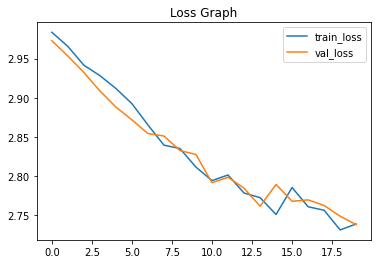

In [ ]:
def plot_loss(train,val,name1="train_loss",name2="val_loss",title=""):
    plt.title(title)
    plt.plot(train, label=name1)
    plt.plot(val, label=name2)
    plt.legend()

plot_loss(train_loss,val_loss,"train_loss","val_loss","Loss Graph")

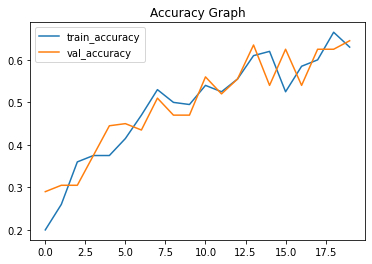

In [ ]:
plot_loss(train_accuracy,val_accuracy,"train_accuracy","val_accuracy","Accuracy Graph")